# Greate Computational Graph 1 

#### 计算图(Computational Graph)

计算图是计算代数中的一个基础处理方法，我们可以通过一个有向图来表示一个给定的数学表达式，并可以根据图的特点快速方便对表达式中的变量进行求导。而神经网络的本质就是一个多层复合函数, 因此也可以通过一个图来表示其表达式。

本部分主要总结计算图的实现，在计算图这个有向图中，每个节点代表着一种特定的运算例如求和，乘积，向量乘积，平方等等… 
##### 例如求和表达式 f(x,y)=x+y 使用有向图表示为:

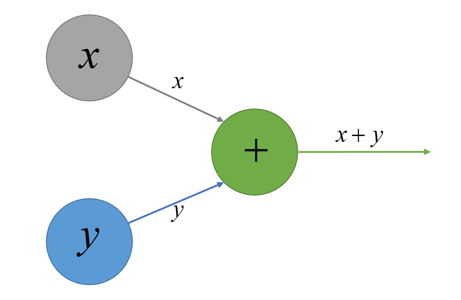

In [19]:
from PIL import Image
size = 600, 300
Image1 = Image.open("Graph_addition.png"); Image1.thumbnail(size); Image1

##### 表达式f(x,y,z)=z(x+y) 使用有向图表示为:

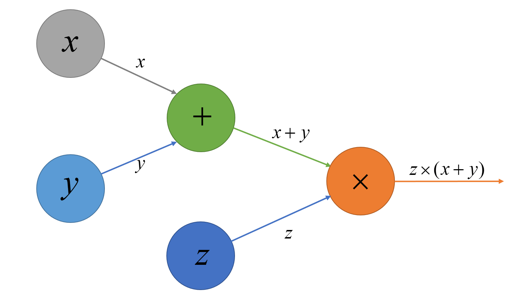

In [18]:
Image2 = Image.open("Graph_addition_plus.png"); Image2.thumbnail(size); Image2

与TensorFlow的实现不同，为了简化，在SimpleFlow中我并没有定义Tensor类来表示计算图中节点之间的数据流动，而是直接定义节点的类型，其中主要定义了四种类型来表示图中的节点:
1. Operation: 操作节点主要接受一个或者两个输入节点然后进行简单的操作运算，例如上图中的加法操作和乘法操作等。
2. Variable: 没有输入节点的节点，此节点包含的数据在运算过程中是可以变化的。
3. Constant: 类似Variable节点，也没有输入节点，此节点中的数据在图的运算过程中不会发生变化
4. Placeholder: 同样没有输入节点，此节点的数据是通过图建立好以后通过用户传入的

其实图中的所有节点都可以看成是某种操作，其中Variable, Constant, Placeholder都是一种特殊的操作，只是相对于普通的Operation而言，他们没有输入，但是都会有输出（像上图中的x,y 节点，他们本身输出自身的值到 + 节点中去），通常会输出到Operation节点，进行进一步的计算。

下面我们主要介绍如何实现计算图的基本组件: 节点和边。

#### Operation节点

节点表示操作，边代表节点接收和输出的数据，操作节点需要含有以下属性:
1. input_nodes: 输入节点，里面存放与当前节点相连接的输入节点的引用
2. output_nodes: 输出节点, 存放以当前节点作为输入的节点，也就是当前节点的去向
3. output_value: 存储当前节点的数值, 如果是Add节点，此变量就存储两个输入节点output_value的和
4. name: 当前节点的名称
5. graph: 此节点所属的图

In [35]:
class Operation(object):
    ''' Base class for all operations in simpleflow.

    An operation is a node in computational graph receiving zero or more nodes
    as input and produce zero or more nodes as output. Vertices could be an
    operation, variable or placeholder.
    '''
    def __init__(self, *input_nodes, name=None):
        ''' Operation constructor.

        :param input_nodes: Input nodes for the operation node.
        :type input_nodes: Objects of `Operation`, `Variable` or `Placeholder`.

        :param name: The operation name.
        :type name: str.
        '''
        # Nodes received by this operation.
        self.input_nodes = input_nodes

        # Nodes that receive this operation node as input.
        self.output_nodes = []

        # Output value of this operation in session execution.
        self.output_value = None

        # Operation name.
        self.name = name

        # Graph the operation belongs to.
        self.graph = DEFAULT_GRAPH

        # Add this operation node to destination lists in its input nodes.
        for node in input_nodes:
            node.output_nodes.append(self)

        # Add this operation to default graph.
        self.graph.operations.append(self)

    def compute_output(self):
        ''' Compute and return the output value of the operation.
        '''
        raise NotImplementedError

    def compute_gradient(self, grad=None):
        ''' Compute and return the gradient of the operation wrt inputs.
        '''
        raise NotImplementedError

在初始化方法中除了定义上面提到的属性外，还需要进行两个操作:
1. 将当前节点的引用添加到他输入节点的output_nodes这样可以在输入节点中找到当前节点。
2. 将当前节点的引用添加到图中，方便后面对图中的资源进行回收等操作

另外，每个操作节点还有两个必须的方法: comput_output和compute_gradient. 他们分别负责根据输入节点的值计算当前节点的输出值和根据操作属性和当前节点的值计算梯度。关于梯度的计算将在后续的文章中详细介绍，本文只对节点输出值的计算进行介绍。

##### 下面我以求和操作为例来说明具体操作节点的实现:

In [36]:
class Add(Operation):
    ''' An addition operation.
    '''
    def __init__(self, x, y, name=None):
        ''' Addition constructor.

        :param x: The first input node.
        :type x: Object of `Operation`, `Variable` or `Placeholder`.

        :param y: The second input node.
        :type y: Object of `Operation`, `Variable` or `Placeholder`.

        :param name: The operation name.
        :type name: str.
        '''
        super(self.__class__, self).__init__(x, y, name=name)

    def compute_output(self):
        ''' Compute and return the value of addition operation.
        '''
        x, y = self.input_nodes
        self.output_value = np.add(x.output_value, y.output_value)
        return self.output_value

#### Variable节点

与Operation节点类似，Variable节点也需要output_value, output_nodes等属性，但是它没有输入节点，也就没有input_nodes属性了，而是需要在创建的时候确定一个初始值initial_value:

In [37]:
class Variable(object):
    ''' Variable node in computational graph.
    '''
    def __init__(self, initial_value=None, name=None, trainable=True): 
        ''' Variable constructor.

        :param initial_value: The initial value of the variable.
        :type initial_value: number or a ndarray.

        :param name: Name of the variable.
        :type name: str.
        '''
        # Variable initial value.
        self.initial_value = initial_value

        # Output value of this operation in session execution.
        self.output_value = None

        # Nodes that receive this variable node as input.
        self.output_nodes = []

        # Variable name.
        self.name = name

        # Graph the variable belongs to.
        self.graph = DEFAULT_GRAPH

        # Add to the currently active default graph.
        self.graph.variables.append(self)
        if trainable:
            self.graph.trainable_variables.append(self)

    def compute_output(self):
        ''' Compute and return the variable value.
        '''
        if self.output_value is None:
            self.output_value = self.initial_value
        return self.output_value

##### Constant节点和Placeholder节点

Constant和Placeholder节点与Variable节点类似，具体实现详见: 
https://github.com/PytLab/simpleflow/blob/master/simpleflow/operations.py

#### 计算图对象

在定义了图中的节点后我们需要将定义好的节点放入到一个图中统一保管，因此就需要定义一个Graph类来存放创建的节点，方便统一操作图中节点的资源。

In [29]:
class Graph(object):
    ''' Graph containing all computing nodes.
    '''
    def __init__(self):
        ''' Graph constructor.
        '''
        self.operations, self.constants, self.placeholders = [], [], []
        self.variables, self.trainable_variables = [], []

为了提供一个默认的图，在导入simpleflow模块的时候创建一个全局变量来引用默认的图:

In [39]:
#from .graph import Graph

# Create a default graph.
import builtins
DEFAULT_GRAPH = builtins.DEFAULT_GRAPH = Graph()

为了模仿TensorFlow的接口，我们给Graph添加上下文管理器协议方法使其成为一个上下文管理器, 同时也添加一个as_default方法:

In [40]:
class Graph(object):
    #...

    def __enter__(self):
        ''' Reset default graph.
        '''
        global DEFAULT_GRAPH
        self.old_graph = DEFAULT_GRAPH
        DEFAULT_GRAPH = self
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        ''' Recover default graph.
        '''
        global DEFAULT_GRAPH
        DEFAULT_GRAPH = self.old_graph

    def as_default(self):
        ''' Set this graph as global default graph.
        '''
        return self

这样在进入with代码块之前先保存旧的默认图对象然后将当前图赋值给全局图对象，这样with代码块中的节点默认会添加到当前的图中。最后退出with代码块时再对图进行恢复即可。这样我们可以按照TensorFlow的方式来在某个图中创建节点.

Ok，根据上面的实现我们已经可以创建一个计算图了:

In [43]:
!pip install simpleflow

    100% |████████████████████████████████| 143kB 7.2MB/s ta 0:00:01
    100% |████████████████████████████████| 819kB 12.9MB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 13.2MB/s ta 0:00:01
    100% |████████████████████████████████| 204kB 16.2MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 11.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for simpleflow ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/82/8e/d1/81c1705952f745e586b7b406083f10e50a2ed415d3c8b1e407
  Running setup.py bdist_wheel for setproctitle ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/e6/b1/a6/9719530228e258eba904501fef99d5d85c80d52bd8f14438a3
  Running setup.py bdist_wheel for websocket-client ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/b0/d2/e2/8275906d09421f074dc2d05381643a0b4b3c4945d845b14bf9
Successfully built simpleflow setproctitle websocket-client
grpcio 1.11.0 has requirement protobuf>=3.5.0.post1, but you'll have protobuf 

In [45]:
import simpleflow as sf

with sf.graph().as_default():
    a = sf.constant([1.0, 2.0], name='a')
    b = sf.constant(2.0, name='b')
    c = a * b

AttributeError: module 'simpleflow' has no attribute 'graph'